# **Proyek Klasifikasi Gambar: Garbage Dataset**
- **Nama:** Rosita Angel Cahyadi
- **Email:** rositaangel143@gmail.com
- **ID Dicoding:** M232D5X1763

## **IMPORT LIBRARY**

In [1]:
import os
import zipfile
import shutil
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from sklearn.metrics import (classification_report, confusion_matrix, ConfusionMatrixDisplay)

import joblib
from PIL import Image

## **DATA PREPERATION**

### **Data Loading**

In [ ]:
import os, pathlib

DATASET_ROOT = "garbage dataset"
print("Root exists:", os.path.exists(DATASET_ROOT))

# Lihat subfolder (kelas)
class_dirs = [d for d in os.listdir(DATASET_ROOT) if os.path.isdir(os.path.join(DATASET_ROOT, d))]
print("Kelas terdeteksi:", sorted(class_dirs))

Root exists: True
Kelas terdeteksi: ['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash']


### **Exploratory Data Analysis (EDA)**

Kelas yang ditemukan (10): ['paper', 'clothes', 'metal', 'cardboard', 'trash', 'glass', 'biological', 'battery', 'plastic', 'shoes']


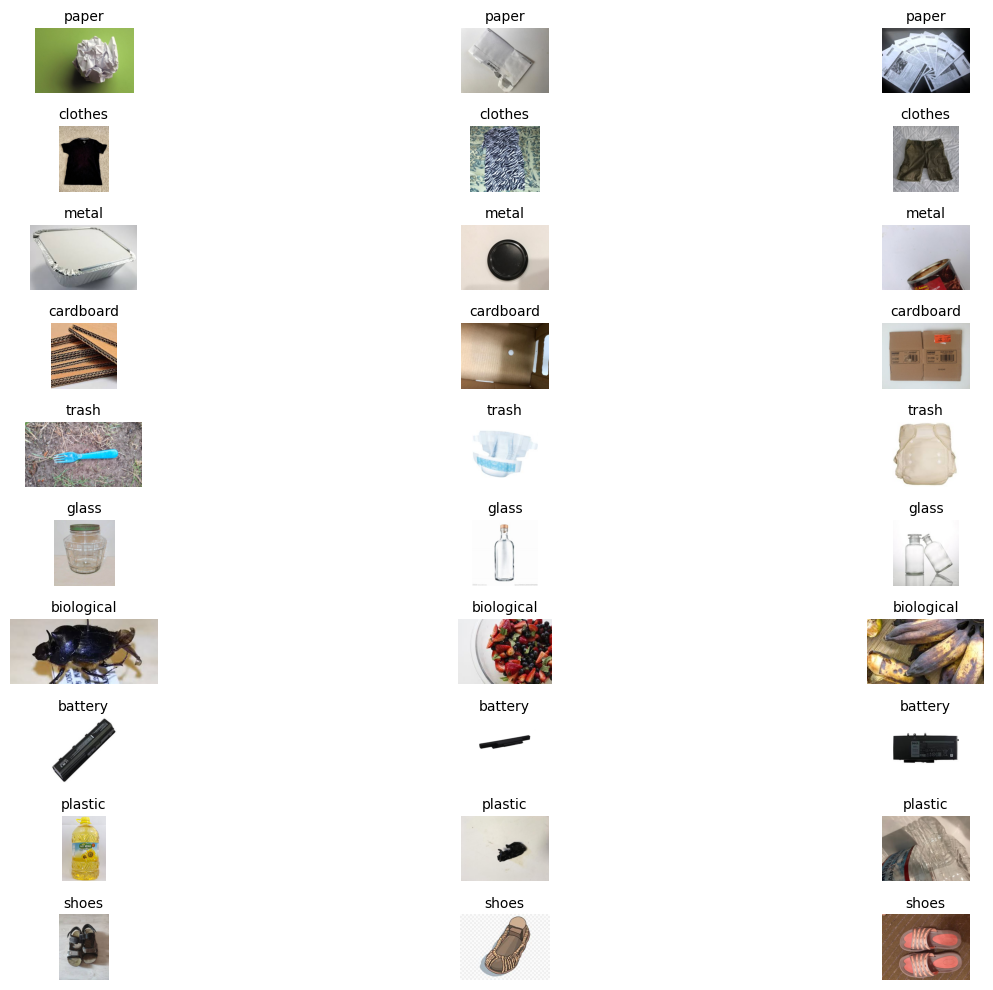

In [3]:
import random

classes = os.listdir(DATASET_ROOT)
print(f"Kelas yang ditemukan ({len(classes)}): {classes}")

plt.figure(figsize=(15, 10))

for i, cls in enumerate(classes):
    class_dir = os.path.join(DATASET_ROOT, cls)
    sample_images = random.sample(os.listdir(class_dir), 3)

    for j, img_name in enumerate(sample_images):
        img_path = os.path.join(class_dir, img_name)
        img = mpimg.imread(img_path)
        ax = plt.subplot(len(classes), 3, i*3 + j + 1)
        plt.imshow(img)
        plt.axis('off')
        ax.set_title(cls, fontsize=10, pad=5, loc='center')

plt.tight_layout()
plt.show()

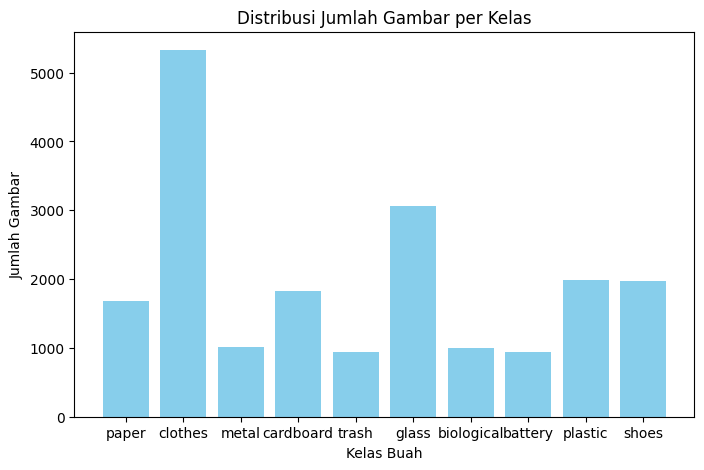

{'paper': 1680, 'clothes': 5327, 'metal': 1020, 'cardboard': 1825, 'trash': 947, 'glass': 3061, 'biological': 997, 'battery': 944, 'plastic': 1984, 'shoes': 1977}


In [ ]:
# Distribusi jumlah gambar per kelas
class_counts = {cls: len(os.listdir(os.path.join(DATASET_ROOT, cls))) for cls in classes}

plt.figure(figsize=(8, 5))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.title("Distribusi Jumlah Gambar per Kelas")
plt.xlabel("Kelas Buah")
plt.ylabel("Jumlah Gambar")
plt.xticks(rotation=0)
plt.show()

print(class_counts)

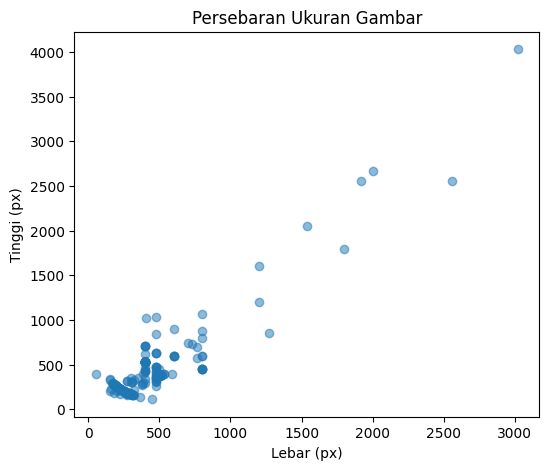

Rata-rata ukuran gambar: 406.5 x 391.9


In [ ]:
# Persebaran ukuran gambar
img_shapes = []

for cls in classes:
    class_dir = os.path.join(DATASET_ROOT, cls)
    for img_name in os.listdir(class_dir)[:30]:
        img_path = os.path.join(class_dir, img_name)
        with Image.open(img_path) as img:
            img_shapes.append(img.size)

img_shapes = np.array(img_shapes)
widths, heights = img_shapes[:, 0], img_shapes[:, 1]

plt.figure(figsize=(6, 5))
plt.scatter(widths, heights, alpha=0.5)
plt.title("Persebaran Ukuran Gambar")
plt.xlabel("Lebar (px)")
plt.ylabel("Tinggi (px)")
plt.show()

print(f"Rata-rata ukuran gambar: {np.mean(widths):.1f} x {np.mean(heights):.1f}")

### **Preprocessing Data**

In [7]:
classes = os.listdir(DATASET_ROOT)

image_paths = []
labels = []

for class_name in classes:
    class_path = os.path.join(DATASET_ROOT, class_name)
    for fname in os.listdir(class_path):
        image_paths.append(os.path.join(class_path, fname))
        labels.append(class_name)

df = pd.DataFrame({
    'filename': image_paths,
    'class': labels
})

df

,filename,class
0,/Users/marlee/.cache/kagglehub/datasets/sumn2u...,paper
1,/Users/marlee/.cache/kagglehub/datasets/sumn2u...,paper
2,/Users/marlee/.cache/kagglehub/datasets/sumn2u...,paper
3,/Users/marlee/.cache/kagglehub/datasets/sumn2u...,paper
4,/Users/marlee/.cache/kagglehub/datasets/sumn2u...,paper
...,...,...
19757,/Users/marlee/.cache/kagglehub/datasets/sumn2u...,shoes
19758,/Users/marlee/.cache/kagglehub/datasets/sumn2u...,shoes
19759,/Users/marlee/.cache/kagglehub/datasets/sumn2u...,shoes
19760,/Users/marlee/.cache/kagglehub/datasets/sumn2u...,shoes


### **Split Data**

In [8]:
train, temp = train_test_split(df, test_size=0.3, stratify=df['class'], random_state=42)
valid, test = train_test_split(temp, test_size=0.5, stratify=temp['class'], random_state=42)

In [9]:
print("Train      :", len(train))
print("Valid      :", len(valid))
print("Test       :", len(test))

Train      : 13833
Valid      : 2964
Test       : 2965


### **Augmentasi dan Normalisasi Data**

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=12,
    zoom_range=(0.8, 1.2),
    brightness_range=(0.7, 1.3),
    channel_shift_range=25.0,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_valid_datagen = ImageDataGenerator(rescale=1./255)

In [11]:
train_ds = train_datagen.flow_from_dataframe(
    train,
    x_col='filename',
    y_col='class',
    target_size = (224, 224),
    batch_size = 32,
    shuffle = True,
    class_mode = 'categorical'
)

valid_ds = test_valid_datagen.flow_from_dataframe(
    valid,
    x_col='filename',
    y_col='class',
    target_size = (224, 224),
    batch_size = 32,
    shuffle = False,
    class_mode = 'categorical'
)

test_ds = test_valid_datagen.flow_from_dataframe(
    test,
    x_col='filename',
    y_col='class',
    target_size = (224, 224),
    batch_size = 32,
    shuffle = False,
    class_mode = 'categorical'
)

Found 13833 validated image filenames belonging to 10 classes.
Found 2964 validated image filenames belonging to 10 classes.
Found 2965 validated image filenames belonging to 10 classes.


## **MODELING**

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

labels = train_ds.classes  
print("Contoh label:", labels[:10])

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
class_weight = dict(enumerate(class_weights))

print("📊 Class weight:", class_weight)

Contoh label: [3, 4, 3, 7, 4, 3, 8, 3, 4, 4]
📊 Class weight: {0: 2.0927382753403934, 1: 1.9818051575931233, 2: 1.083241973375098, 3: 0.37095736122284795, 4: 0.6457983193277311, 5: 1.9373949579831933, 6: 1.1762755102040816, 7: 0.9958963282937365, 8: 0.9994942196531792, 9: 2.086425339366516}


Arsitektur Model

In [13]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Sequential, Input, layers, models, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)
for layer in base_model.layers[:-30]:
    layer.trainable = False

model = Sequential([
    base_model,

    layers.SeparableConv2D(64, (3,3), padding='same', activation='relu'),
    layers.BatchNormalization(trainable=False),

    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    layers.Dropout(0.5),

    layers.Dense(10, activation='softmax', dtype='float32')
])

2025-11-05 23:53:22.694426: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-11-05 23:53:22.694463: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-11-05 23:53:22.694467: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-11-05 23:53:22.694603: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-11-05 23:53:22.694614: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [ ]:
# Callbacks
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Compile model
from tensorflow.keras.optimizers import Adam
model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Training Model

In [15]:
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=20,
    callbacks=[early_stop],
    class_weight=class_weight,
    verbose=1
)

Epoch 1/20


2025-11-05 23:53:25.807776: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


433/433 ━━━━━━━━━━━━━━━━━━━━ 113s 246ms/step - accuracy: 0.7591 - loss: 0.8454 - val_accuracy: 0.7217 - val_loss: 1.5032
Epoch 2/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 116s 267ms/step - accuracy: 0.8729 - loss: 0.4630 - val_accuracy: 0.8522 - val_loss: 0.7673
Epoch 3/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 97s 223ms/step - accuracy: 0.8941 - loss: 0.3674 - val_accuracy: 0.9005 - val_loss: 0.4595
Epoch 4/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 98s 226ms/step - accuracy: 0.9099 - loss: 0.3149 - val_accuracy: 0.9042 - val_loss: 0.5007
Epoch 5/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 113s 260ms/step - accuracy: 0.9184 - loss: 0.2708 - val_accuracy: 0.9113 - val_loss: 0.4964
Epoch 6/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 103s 238ms/step - accuracy: 0.9264 - loss: 0.2535 - val_accuracy: 0.9258 - val_loss: 0.3616
Epoch 7/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 111s 256ms/step - accuracy: 0.9346 - loss: 0.2209 - val_accuracy: 0.8957 - val_loss: 0.5034
Epoch 8/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 108s 248ms/step - accuracy: 0.9430 - loss: 0.2042

## **EVALUASI DAN VISUALISASI**

In [ ]:
train_acc = history.history['accuracy'][-1]
val_acc   = history.history['val_accuracy'][-1]

test_loss, test_acc = model.evaluate(test_ds, verbose=1)

print("MODEL PERFORMANCE")
print(f"Train Accuracy     : {train_acc*100:.2f}%")
print(f"Validation Accuracy: {val_acc*100:.2f}%")
print(f"Test Accuracy      : {test_acc*100:.2f}%")

93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - accuracy: 0.9288 - loss: 0.3298
MODEL PERFORMANCE
Train Accuracy     : 94.39%
Validation Accuracy: 91.13%
Test Accuracy      : 92.88%


93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - accuracy: 0.9288 - loss: 0.3298

Test Loss : 0.3298
Test Acc  : 0.9288
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step
Classification Report
              precision    recall  f1-score   support

     battery     0.9252    0.9645    0.9444       141
  biological     0.9408    0.9597    0.9502       149
   cardboard     0.9286    0.9015    0.9148       274
     clothes     0.9924    0.9750    0.9836       799
       glass     0.9643    0.8804    0.9205       460
       metal     0.8204    0.8954    0.8562       153
       paper     0.8929    0.8929    0.8929       252
     plastic     0.8429    0.9362    0.8871       298
       shoes     0.9589    0.9428    0.9508       297
       trash     0.8039    0.8662    0.8339       142

    accuracy                         0.9288      2965
   macro avg     0.9070    0.9215    0.9134      2965
weighted avg     0.9316    0.9288    0.9295      2965



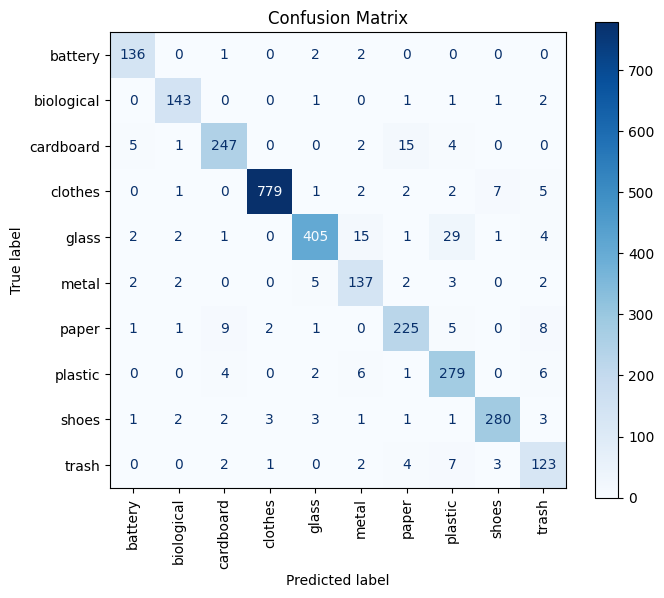

In [ ]:
test_ds.reset()
test_loss, test_acc = model.evaluate(test_ds, verbose=1)
print(f"\nTest Loss : {test_loss:.4f}")
print(f"Test Acc  : {test_acc:.4f}")

test_ds.reset()
y_prob = model.predict(test_ds, verbose=1)
y_pred = np.argmax(y_prob, axis=1)

y_true_batches = []
test_ds.reset()
for _, yb in test_ds:
    if len(y_true_batches) * test_ds.batch_size >= test_ds.n:
        break
    if test_ds.class_mode == 'categorical':
        y_true_batches.append(np.argmax(yb, axis=1))
    else: 
        y_true_batches.append(yb.astype(int).ravel())
y_true = np.concatenate(y_true_batches, axis=0)[:test_ds.n]

class_indices = train_ds.class_indices
idx_to_class = {v: k for k, v in class_indices.items()}
class_names = [idx_to_class[i] for i in range(len(class_indices))]

print("Classification Report")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

cm = confusion_matrix(y_true, y_pred, labels=range(len(class_names)))

fig, ax = plt.subplots(figsize=(7, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(ax=ax, cmap="Blues", xticks_rotation=90, colorbar=True)
ax.set_title("Confusion Matrix")

plt.tight_layout()
plt.show()

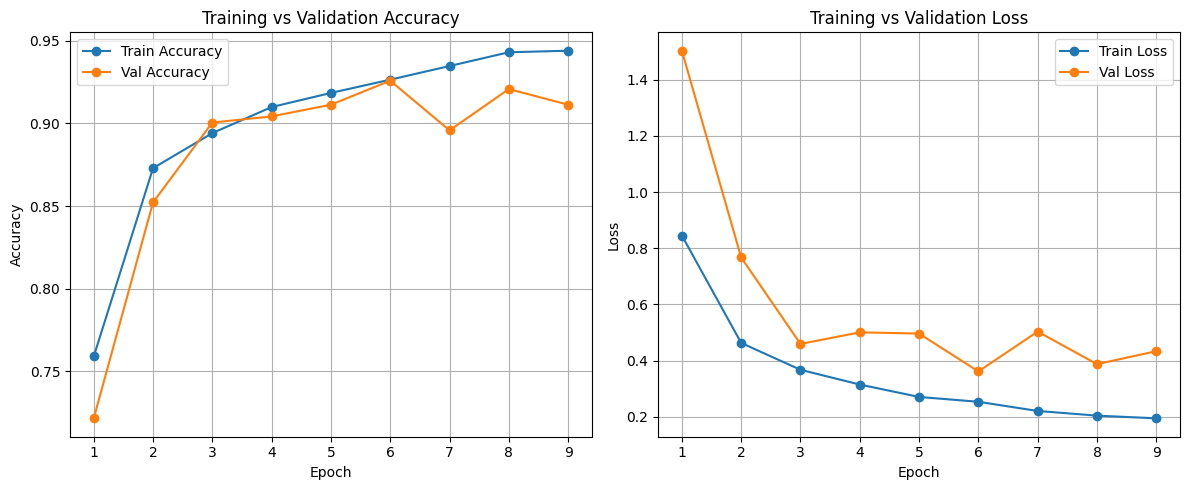

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Val Accuracy', marker='o')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Val Loss', marker='o')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## **KONVERSI MODEL**

SavedModel

In [ ]:

model.export("saved_model/garbage_model")

INFO:tensorflow:Assets written to: saved_model/garbage_model/assets


INFO:tensorflow:Assets written to: saved_model/garbage_model/assets


Saved artifact at 'saved_model/garbage_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_154')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  13213186912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13213187440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13213187264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13213187792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13213186560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13213187088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13213549136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13213548960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13213549488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13213549312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13213549664: TensorSpec(shape=(), dtype=

Save Model tflite

In [20]:
import os

# --- Buat folder tflite ---
os.makedirs("tflite", exist_ok=True)

# --- Konversi ke TFLite ---
converter = tf.lite.TFLiteConverter.from_saved_model("saved_model/garbage_model")
tflite_model = converter.convert()

# --- Simpan model.tflite ---
with open("tflite/model.tflite", "wb") as f:
    f.write(tflite_model)

labels = sorted(os.listdir(DATASET_ROOT))
with open("tflite/label.txt", "w") as f:
    f.write("\n".join(labels))

W0000 00:00:1762362617.670584 2068589 tf_tfl_flatbuffer_helpers.cc:390] Ignored output_format.
W0000 00:00:1762362617.670843 2068589 tf_tfl_flatbuffer_helpers.cc:393] Ignored drop_control_dependency.
2025-11-06 00:10:17.677948: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: saved_model/garbage_model
2025-11-06 00:10:17.684002: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2025-11-06 00:10:17.684011: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: saved_model/garbage_model
2025-11-06 00:10:17.796605: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2025-11-06 00:10:17.810437: I tensorflow/cc/saved_model/loader.cc:234] Restoring SavedModel bundle.
2025-11-06 00:10:18.290601: I tensorflow/cc/saved_model/loader.cc:218] Running initialization op on SavedModel bundle at path: saved_model/garbage_model
2025-11-06 00:10:18.413500: I tensorfl

Save Model Tensorflowjs

In [2]:
import tensorflowjs as tfjs
tfjs.converters.convert_tf_saved_model(
    "saved_model/garbage_model",
    "tfjs_model/"
)

## **INFERENCE MODEL**

terdeteksi: ['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash']


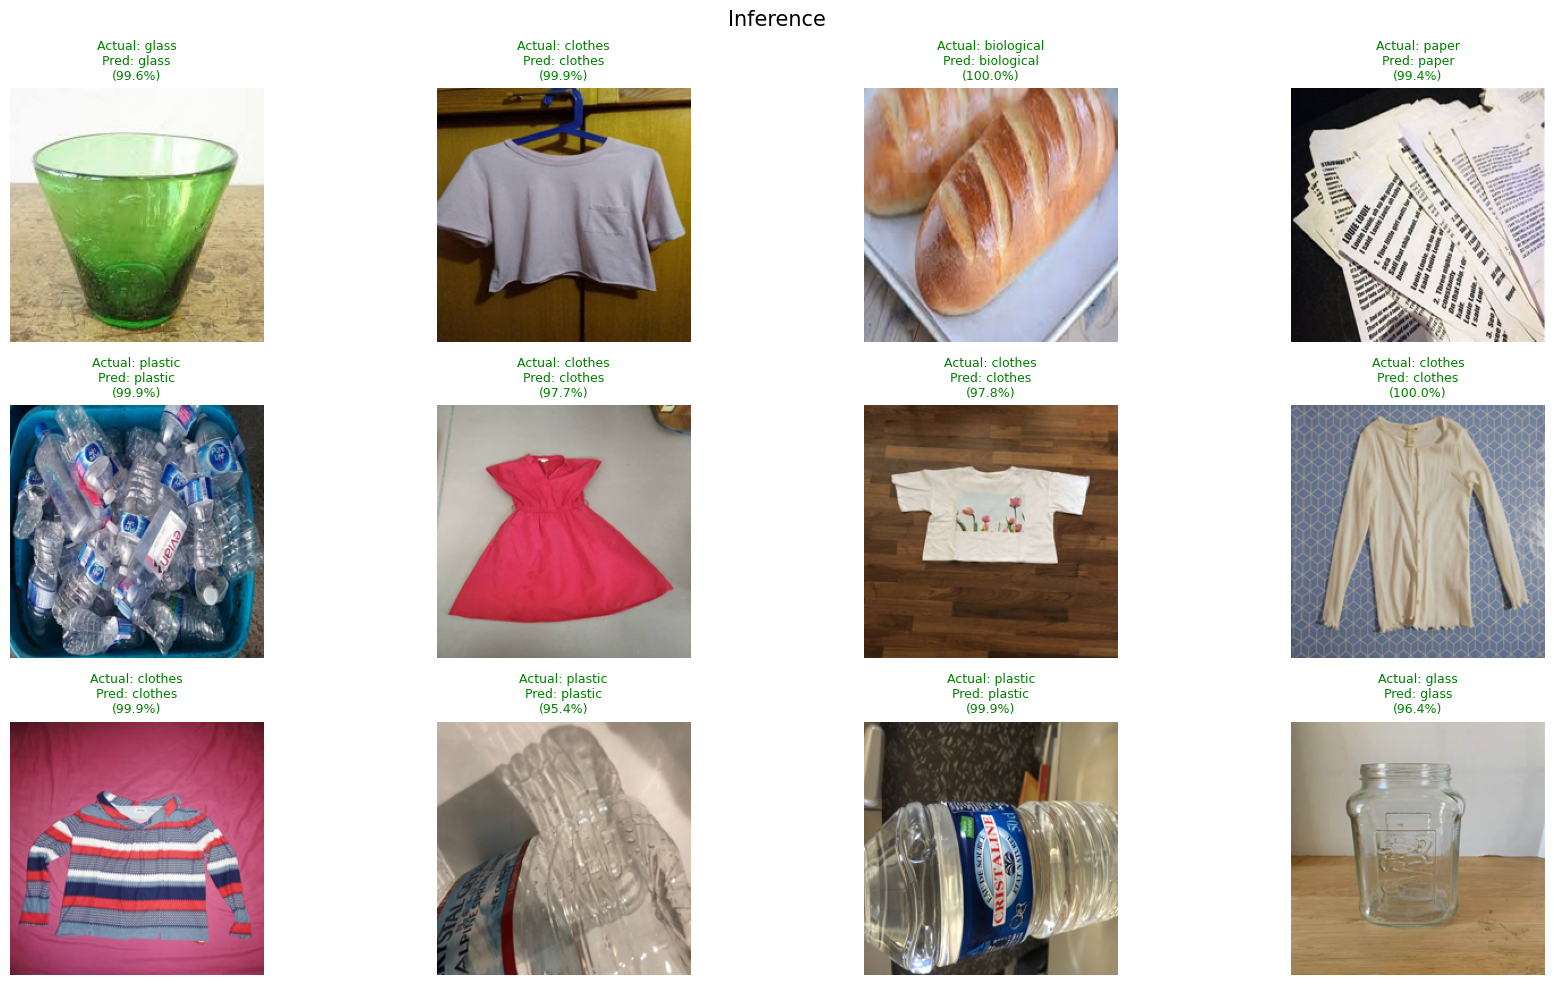

In [ ]:
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
import random

tflite_path = "tflite/model.tflite"
label_path = "tflite/label.txt"
dataset_path = "garbage dataset"

with open(label_path, "r") as f:
    class_names = [line.strip() for line in f.readlines()]
print("terdeteksi:", class_names)

interpreter = tf.lite.Interpreter(model_path=tflite_path)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

def predict_tflite(image_path):
    img = Image.open(image_path).resize((224, 224)).convert('RGB')
    input_data = np.expand_dims(np.array(img, dtype=np.float32) / 255.0, axis=0)

    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])

    predicted_class = np.argmax(output_data)
    confidence = np.max(output_data)
    return class_names[predicted_class], confidence, img

all_images = []
for cls in class_names:
    class_dir = os.path.join(dataset_path, cls)
    images = [os.path.join(class_dir, f) for f in os.listdir(class_dir)]
    all_images.extend(images)

sample_images = random.sample(all_images, 12)

plt.figure(figsize=(18, 10))
for i, img_path in enumerate(sample_images):
    actual_class = os.path.basename(os.path.dirname(img_path))
    predicted_class, conf, img = predict_tflite(img_path)

    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.axis('off')

    color = 'green' if actual_class == predicted_class else 'red'
    plt.title(f"Actual: {actual_class}\nPred: {predicted_class}\n({conf*100:.1f}%)",
              color=color, fontsize=9)

plt.suptitle("Inference", fontsize=15)
plt.tight_layout()
plt.show()